# GAN: REDES GENERATIVAS ADVERSARIALES
Utilice el conjunto de datos Fashion-MNIST para construir una red generativa adversarial (GAN) que genere imágenes de productos de moda. Para la construcción del modelo utilice los esquemas que se describen a continuación y compare los resultados:

1. Definir un generador basado en una red neuronal convolucional (practica 1).
2. Definir un discriminador basado en una red neuronal convolucional (practica 2).
3. Definir un modelo GAN que conecte el generador y el discriminador (practica 3).
4. Entrenar el modelo GAN con el conjunto de datos Fashion-MNIST.
5. Generar imágenes de productos de moda con el modelo GAN.

Compruebe con ejemplos que el modelo es capaz de generar imágenes de productos de moda.

## OBJETIVO
Aplicar el proceso de aprendizaje para reconstruir imágenes de productos utilizando redes neuronales convolucionales profundas.

## DATOS
Incluidos en Keras.
También, existe otra fuente equivalente que se consigue en el siguiente URL https://www.kaggle.com/zalando-research/fashionmnist donde hay un resumen de estos datos en el archivo CVS y XLSX.

la clasificación para el aprendizaje supervisado es:

    Label 	Class
    0 	 	T-shirt/top
    1 	 	Trouser
    2 	 	Pullover
    3 	 	Dress
    4 	 	Coat
    5 	 	Sandal
    6 	 	Shirt
    7 	 	Sneaker
    8 	 	Bag
    9 	 	Ankle boot

**Importante: Lea los comentarios y apuntes del Notebook para tener claridad de los pasos.**

### Consideraciones
- Utilice sólo los conjuntos de datos indicado.
- El frameworks a utilizar es TensorFlow, Keras con Jupyter Notebbooks.

### Enlaces de interés
- documentación Keras, URL: https://keras.io/models/sequential/
- documentación TensorFlow, URL: https://www.tensorflow.org/versions
- Tutorial CNN basico, URL: https://www.kaggle.com/nhlr21/deep-keras-cnn-tutorial/notebook
- Tutorial GAN, URL: https://www.kaggle.com/insaff/img2img-gan-using-keras
- Video tutorial GAN, URL: https://www.youtube.com/watch?v=AALBGpLbj6Q


## Importando Librerias

In [1]:
# importando dependencias de trabajo
# importando librerias basicas
import os
import gc

# importando modulos de analisis de datos, ML y graficas
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

# importando dependencias para tensorflow
from keras.datasets import fashion_mnist
from keras.utils import to_categorical


# importando para sklearn
from sklearn.model_selection import train_test_split

# importando para modelos de keras
from keras.models import Model
# importando capas de keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D

# funciones de optimizacion y perdida
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.losses import BinaryCrossentropy

# funciones para callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img

2024-02-28 20:34:45.390116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 20:34:45.390200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 20:34:45.391283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 20:34:45.397567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 20:34:46.352801: W tensorflow/compiler/tf2

In [2]:
# 3 revisando la presencia de la GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-02-28 20:34:47.952694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:34:48.006279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:34:48.006419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# configurando la memoria de la GPU y evitando el consumo total de la memoria
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Funciones Utiles

In [4]:
# funcion que recibe una lista numpy y recupera la forma de cada elemento, devuelve una lista con formas
def get_shape(data):
    # respuesta de la funcion
    ans = list()

    for d in data:
        sp = d.shape
        ans.append(sp)
    return ans

In [5]:
# funcion que transforma el entero de la clase a la palabra de la etiqueta, devuelve una lista de etiquetas
def class2label(data, labels):
    # respuesta de la funcion
    ans = list()

    for d in data:
        d = int(d)
        l = str(labels[d])
        ans.append(l)
    return ans

In [6]:
# funcion que estandariza los datos en numpy de acuerdo a un valor min & max, devuelve un arreglo np flotante
def std_data(data, minv, maxv):
    rangev = maxv - minv
    ans = data.astype("float32")/float(rangev)
    # respuesta de la funcion
    return ans

## Cargar y Preparar los Datos

Los pasos de esta sección son:

1. Leer los datos desde MNIST.
2. Formatear los datos para que los acepte el DataFrame de Pandas.
2. Crear el DataFrame de Pandas con un esquema propio.
2. Formatear los datos MNIST para pobrar el DataFrame de pandas.
3. Revisar que todo este como debería estar.

In [7]:
# lista de nombres de las clasificaciones
label_names=[     # label number
    "T-shirt/top",      # 0
    "Trouser",          # 1
    "Pullover",         # 2
    "Dress",            # 3
    "Coat",             # 4
    "Sandal",           # 5
    "Shirt",            # 6
    "Sneaker",          # 7
    "Bag",              # 8
    "Ankle boot"        # 9
]

In [8]:
# se carga el archivo de datos de trabajo por medio de Keras
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [9]:
# nombres de columnas para el dataframe de pandas
col_names = [           # nombre de columna DF
    "img_data",         # datos de la imagen
    "img_shape",        # forma de la imagen
    "class",            # clase de la imagen, de 0 a 9
    "label",            # nombre de la clase
    "std_img_data",     # datos de la imagen estandarizados
    "cat_labels"        # etiquetas categoricas de la clase
]
# "ReshapeData", "Label", "Class", "DataSize", "ReshapeSize", "ResKeras", "ScoreKeras"]
# creando dataframe con columnas
fashion_df = pd.DataFrame(columns=col_names)

In [10]:
# integrando datos de mnist
img_data = np.concatenate((x_train, x_test), axis = 0)
class_data = np.concatenate((y_train, y_test), axis = 0)
# recuperando forma de imagenes
img_shape = get_shape(img_data)
# recuperando etiquetas de las clases
labels = class2label(class_data, label_names)
# estandarizar los datos de la imagen
std_img_data = std_data(img_data, 0, 255)
# categorizando las clases a aprender
cat_labels = to_categorical(class_data, len(label_names))

In [11]:
# cambio de formato para utilizar el dataframe
img_data = img_data.tolist()
std_img_data = std_img_data.tolist()
cat_labels = cat_labels.tolist()

In [12]:
# definir arreglo basico de datos
data_lt = (
    img_data,       # datos de la imagen   0
    img_shape,      # forma de la imagen   1
    class_data,     # clase de la imagen   2
    labels,         # nombre de la clase   3
    std_img_data,   # datos de la imagen estandarizados 4
    cat_labels,     # etiquetas categoricas de la clase 5
)

In [13]:
# poblamdo las columnas del dataframe
for col, data in zip(col_names, data_lt):
    fashion_df[col] = data

In [14]:
# informacion del dataframe
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img_data      70000 non-null  object
 1   img_shape     70000 non-null  object
 2   class         70000 non-null  uint8 
 3   label         70000 non-null  object
 4   std_img_data  70000 non-null  object
 5   cat_labels    70000 non-null  object
dtypes: object(5), uint8(1)
memory usage: 2.7+ MB


In [15]:
# imprime el encabezado del dataframe
fashion_df.head()

,img_data,img_shape,class,label,std_img_data,cat_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(28, 28)",9,Ankle boot,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, ...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156885936856...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64...","(28, 28)",3,Dress,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
# libero memoria
gc.collect()

0

## Revisando los Datos
Es importante revisar los datos para saber que se esta trabajando con ellos. En esta sección se revisa la forma de los datos, se visualizan algunas imágenes y se revisa la distribución de las clases.

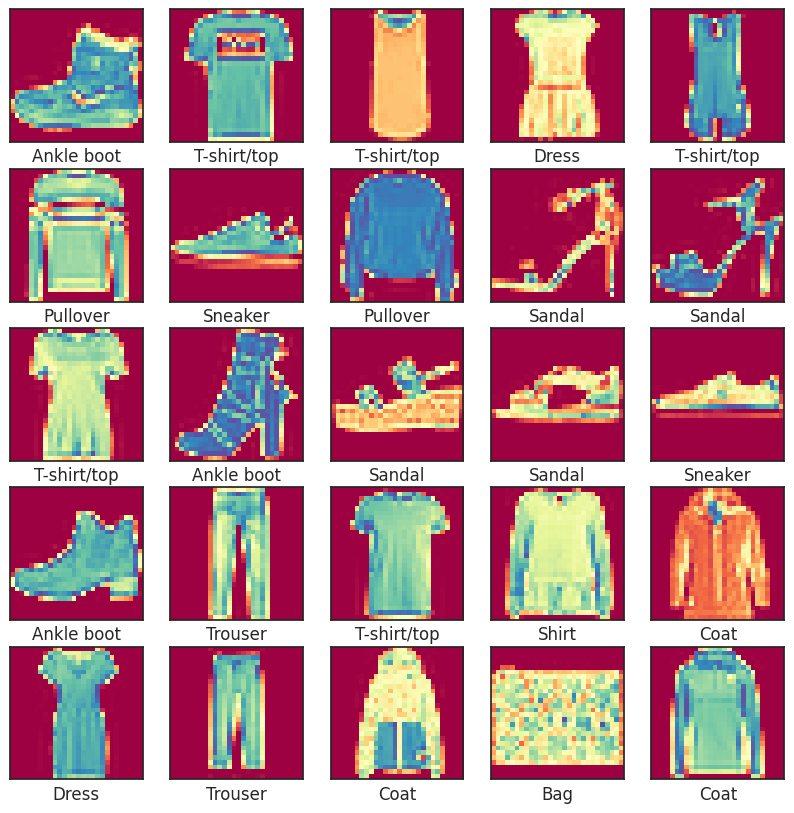

In [17]:
# pruebo imagenes del dataset
# imagen de 5x5 subplots con tamaño de 10x10
sns.set_theme(style="white")
plt.figure(figsize=(10,10))
# recorriendo las imagenes
for i in range(25):
    # creando subplots
    plt.subplot(5,5,i+1)
    # xticks y yticks desactivados
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # tomo la imagen de la columna de datos de la imagen
    # el mapa de colores es viridis de matplotlib
    # otras opciones son: "plasma", "viridis", "BuPu", "hsv", "Spectral"
    plt.imshow(fashion_df["img_data"][i], cmap=plt.cm.Spectral)
    # tomo el nombre de la clase de la columna de etiquetas
    plt.xlabel(fashion_df["label"][i])

## Preprocesar los Datos

Los pasos de esta sección son:

1. Revisar que los datos están bien.
2. Elegir la características o propiedades de aprendizaje.
3. Elegir la variable objetivo del aprendizaje.
4. Dividir el conjunto de datos entre las poblaciones de entrenamiento y pruebas.
5. Formatear los datos de aprendizaje y objetivo acorde a la red neuronal.

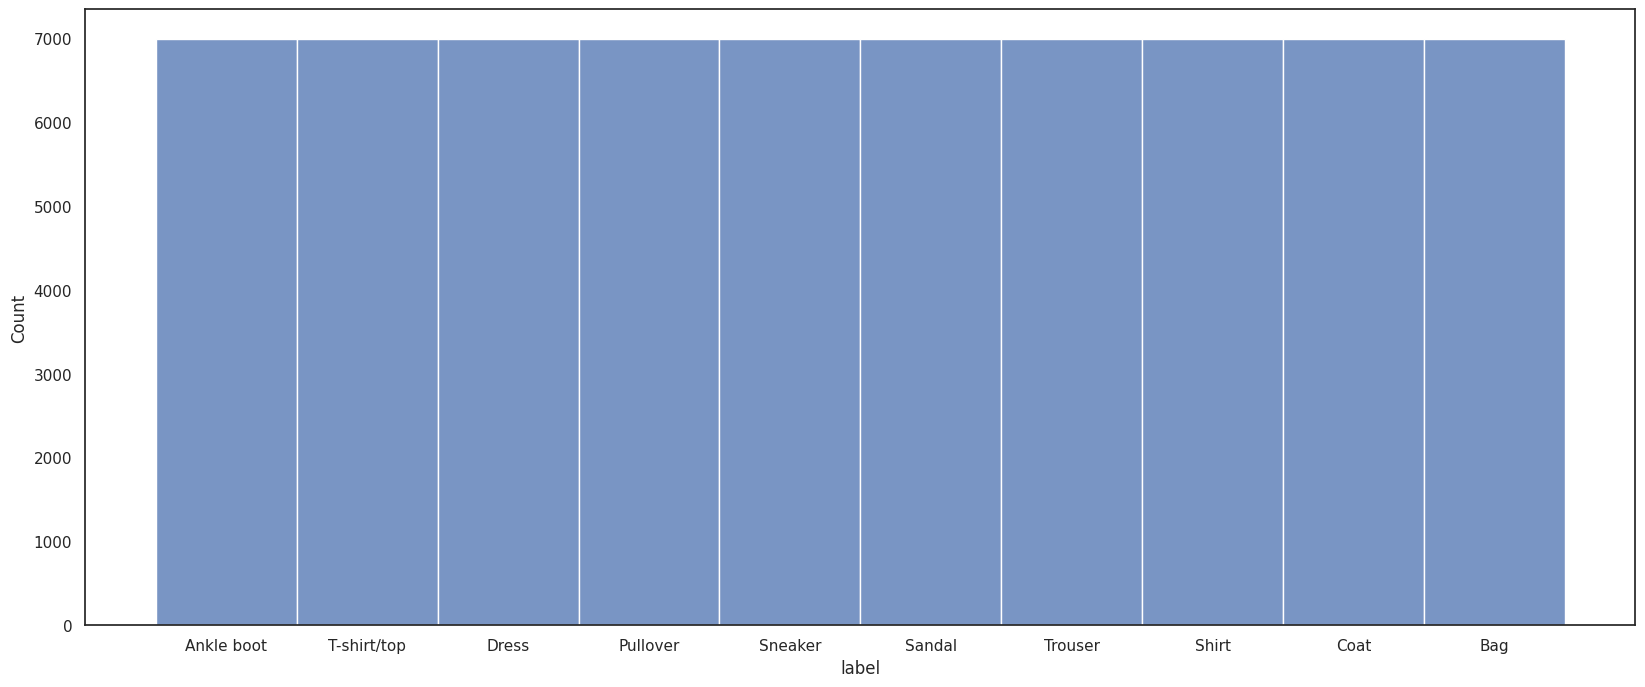

In [18]:
# chequeo la distribucion de datos
sns.set_theme(style="white")
plt.figure(figsize=(20, 8))
sns.histplot(fashion_df[col_names[3]])
plt.show()

In [19]:
# seleccionando caracteristicas de aprendizaje y variables objetivo
# recuperando la forma de las imagenes basado en el primer elemento de la lista

# recuperando los valores y ajustando el tensor para la CNN
A = fashion_df[col_names[4]]
# recuperando los valores de la cateogoria
b = fashion_df[col_names[5]].values

# fortateo de datos numpy
X = np.array([np.array(i, dtype="object") for i in A], dtype="object")
y = np.array([np.array(j, dtype="object") for j in b], dtype="object")

print(X.shape)
# forma basica general de las imagenes
imgsh = X[0].shape
# ajuste de forma para el modelo CNN
X = X.reshape(fashion_df.shape[0], imgsh[0], imgsh[1], 1)
print(X.shape)

(70000, 28, 28)
(70000, 28, 28, 1)


In [20]:
# semilla para el random
rseed = 42
# rseed = np.random.seed()

# en tamanho de la muestra para pruebas esta entre 0.2 y 0.3
train_pop = 0.8
test_pop = 1.0 - train_pop

In [21]:
# distribuir los datos entre entrenamiento vs. pruebas
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_pop, random_state=rseed)

In [22]:
# formateo para keras y tensorflow
X_train = tf.convert_to_tensor(X_train, dtype="float64")
y_train = tf.convert_to_tensor(y_train, dtype="float64")
X_test = tf.convert_to_tensor(X_test, dtype="float64")
y_test = tf.convert_to_tensor(y_test, dtype="float64")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

2024-02-28 20:35:15.006379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:35:15.006815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:35:15.007053: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:35:15.370147: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:35:15.370351: I external/local_xla/xla/stream_executor

(56000, 28, 28, 1) (56000, 10) (14000, 28, 28, 1) (14000, 10)


2024-02-28 20:35:20.660353: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 87808000 exceeds 10% of free system memory.


## Crear las bases para la GAN

### Variables de Entrada y configuración de los modelos

In [23]:
# defino parametros necesarios para el modelo Autoencoder
# parametros para las capas
filters = 32    # 32, 64, 128
# TODO cambiar el numero de neuronas de la capa intermedia
# lat_neurons, v1 = 7*7, v2 = 28*28
lat_neurons = 7*7

# TODO cambiar la dimension del reshape convolucional
# mid_reshape, v1 = (7, 7, 1), v2 = (28, 28, 1)
mid_reshape = (7, 7, 1)
ksize = (3, 3)

# TODO cambiar el tamano del pool para reducir la imagen
# psize, v1 = (2, 2), v2 = (1, 1)
psize = (2, 2)

# numero de categorias en la salida
categories = len(label_names)
# numero de neuronas en la capa de salida
outn_gen = 1
outn_dis = categories//categories

# funcion de activacion para las capas convolucionales
# otras opciones son: # "relu", "LeakyReLU"
act = "LeakyReLU"
# funcion de activacion para la capa de salida
# otras opciones son: # "sigmoid", "softmax"
out = "sigmoid"
# padding para las capas convolucionales
pad = "same"
# porcentaje de dropout para imagenes
ldrop_gen = 0.2
ldrop_dis = 0.4

# forma del kernel de entrada y de las capas intermedias
inshape_gen = (lat_neurons)
inshape_dis = X[0].shape

### Funciones de Ayuda

In [24]:
def build_model(layers):
    """build_model crea un modelo secuencial de keras con las capas definidas.

    Args:
        layers (list[Layers]): lista de capas de tensorflow/keras.

    Returns:
        Model: modelo secuencial de keras.
    """    
    # se crea el modelo secuencial
    model = Sequential()
    # se recorre la lista de capas
    for layer in layers:
        # se agrega la capa al modelo
        model.add(layer)
    return model

#### Capas del Generador

In [25]:
# definicion de las capas para el generador de imagenes
gen_layer_lt = (
    # capa de entrada
    Input(shape=inshape_gen,
          name="LayIn"),

    # capa intermedia densamente poblada con regularizacion
    Dense(lat_neurons,
          activation=act,
          name="latentDense"),
    # capa intermedia de 1D a 2D
    Reshape(mid_reshape,
            name="layReshape"),

    # capa convolucional intermedia con regularizacion
    Conv2D(int(filters/2),
           ksize,
           activation=act,
           padding=pad,
           name="DeConv1"),
    UpSampling2D(psize,
                 name="DeUpsam1"),
    Dropout(ldrop_gen,
            name="DeDrop1"),

    # capa convolucional intermedia con regularizacion
    Conv2D(filters,
           ksize,
           activation=act,
           padding=pad,
           name="DeConv2"),
    UpSampling2D(psize,
                 name="DeUpsam2"),
    Dropout(ldrop_gen,
            name="DeDrop2"),

    # capa de salida
    Conv2D(outn_gen,
           ksize,
           activation=out,
           padding=pad,
           name="LayOut"),
)

#### Capas del Discriminador

In [26]:
# definicion de las capas para el discriminador de imagenes
dis_layer_lt = (
    # capa de entrada
    Input(shape=inshape_dis,
          name="LayIn"),

    # capa convolucional intermedia con regularizacion
    Conv2D(filters,
           ksize,
           activation=act,
           padding=pad,
           name="EnConv1"),
    MaxPooling2D(psize,
                 padding=pad,
                 name="EnPool1"),
    Dropout(ldrop_dis,
            name="EnDrop1"),

    # capa convolucional intermedia con regularizacion
    Conv2D(int(filters/2),
           ksize,
           activation=act,
           padding=pad,
           name="EnConv2"),
    MaxPooling2D(psize,
                 padding=pad,
                 name="EnPool2"),
    Dropout(ldrop_dis,
            name="EnDrop2"),

    # capa intermedia de 2D a 1D
    Flatten(name="LayFlat"),
    # capa intermedia densamente poblada con regularizacion
    Dense(lat_neurons,
          activation=act,
          name="DenseMid"),
    Dropout(ldrop_dis,
            name="MidDrop"),

#     # capa densa para clasificar los datos
#     Dense(int(lat_neurons)//2,
#           activation=act,
#           name="ClsDense1"),
#     Dropout(ldrop_dis,
#             name="ClsDrop1"),

#     # capa densa para clasificar los datos
#     Dense(int(lat_neurons)//4,
#           activation=act,
#           name="ClsDense2"),
#     Dropout(ldrop_dis,
#             name="ClsDrop2"),

    # capa de salida
    Dense(outn_dis,
          activation=out,
          name="LayOut")
)

#### Crear el Generador

In [27]:
# creo el modelo del generador
generator = build_model(gen_layer_lt)
# reviso el modelo
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latentDense (Dense)         (None, 49)                2450      
                                                                 
 layReshape (Reshape)        (None, 7, 7, 1)           0         
                                                                 
 DeConv1 (Conv2D)            (None, 7, 7, 16)          160       
                                                                 
 DeUpsam1 (UpSampling2D)     (None, 14, 14, 16)        0         
                                                                 
 DeDrop1 (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 DeConv2 (Conv2D)            (None, 14, 14, 32)        4640      
                                                                 
 DeUpsam2 (UpSampling2D)     (None, 28, 28, 32)        0

La imagen del modelo esta en: Models/discws_gan_generator.png


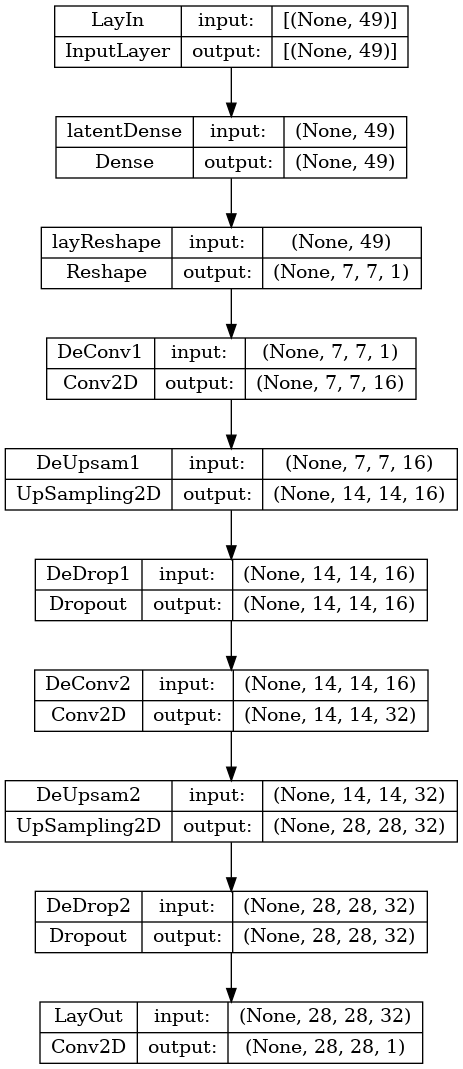

In [28]:
# imprimo imagen de la topologia del modelo
wdir = os.getcwd()
folder_models = "Models"
model_fn = "discws_gan_generator.png"
model_fp = os.path.join(folder_models, model_fn)
print("La imagen del modelo esta en:", model_fp)
keras.utils.plot_model(generator,
                       model_fp,
                       show_shapes=True)

2024-02-28 20:35:23.405459: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-28 20:35:24.134114: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


2024-02-28 20:35:25.486629: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


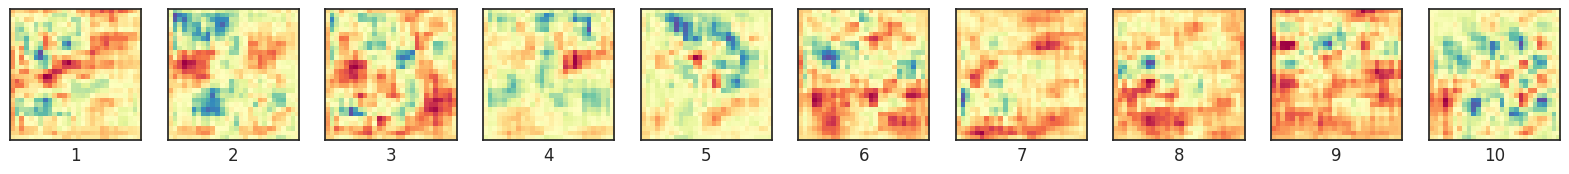

In [29]:
# desplegando pruebas
sns.set_theme(style="white")
plt.figure(figsize=(20, 10))
# Genera 10 imagenes con el modelo generador SIN ENTRENAR!
latent_input = np.random.randn(categories, lat_neurons, 1)
gen_img_lt = generator.predict(latent_input)

for i, img in enumerate(gen_img_lt):
    # imagen generada con el modelo
    ax = plt.subplot(3, categories, i + 1)
    temp_X = np.array(img)

    # ajustar ty tamaño y color al original
    plt.imshow(temp_X,
               cmap=plt.cm.Spectral)
    # imprimir el indice de la imagen
    plt.xlabel(i+1)
    plt.xticks([])
    plt.yticks([])

#### Crear el Discriminador

In [30]:
discriminator = build_model(dis_layer_lt)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EnConv1 (Conv2D)            (None, 28, 28, 32)        320       
                                                                 
 EnPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
                                                                 
 EnDrop1 (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 EnConv2 (Conv2D)            (None, 14, 14, 16)        4624      
                                                                 
 EnPool2 (MaxPooling2D)      (None, 7, 7, 16)          0         
                                                                 
 EnDrop2 (Dropout)           (None, 7, 7, 16)          0         
                                                                 
 LayFlat (Flatten)           (None, 784)              

La imagen del modelo esta en: Models/discws_gan_discriminator.png


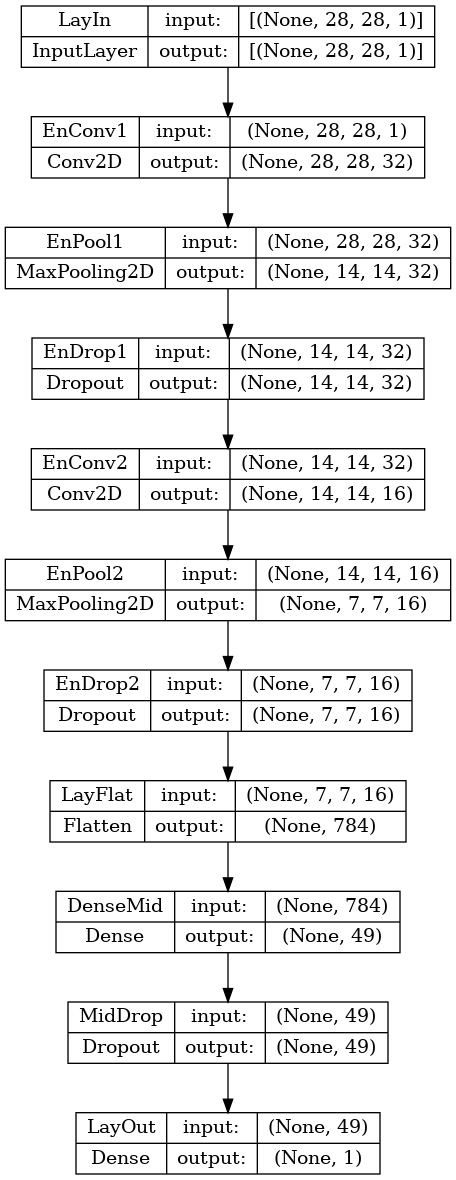

In [31]:
# imprimo imagen de la topologia del modelo
wdir = os.getcwd()
folder_models = "Models"
model_fn = "discws_gan_discriminator.png"
model_fp = os.path.join(folder_models, model_fn)
print("La imagen del modelo esta en:", model_fp)
keras.utils.plot_model(discriminator,
                       model_fp,
                       show_shapes=True)

1/1 [==============================] - 1s 887ms/step


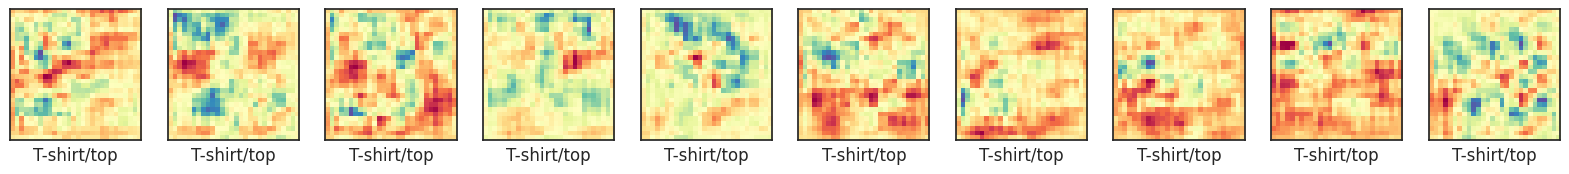

In [32]:
# desplegando pruebas
sns.set_theme(style="white")
plt.figure(figsize=(20, 10))
# Genera 10 imagenes con el modelo discriminador SIN ENTRENAR!
dis_img_lt = discriminator.predict(gen_img_lt)

for i, label in enumerate(dis_img_lt):
    # imagen generada con el modelo
    ax = plt.subplot(3, categories, i + 1)
    temp_X = np.array(gen_img_lt[i])

    # ajustar ty tamaño y color al original
    plt.imshow(temp_X,
               cmap=plt.cm.Spectral)

    # imprimir el nombre de la clase
    idx = list(label).index(max(label))
    # print(idx, label_names[idx])
    # print(label_names)
    plt.xlabel(label_names[idx])
    plt.xticks([])
    plt.yticks([])

## Crear Modelo GAN

### Configurar funciones de perdida y optimizadores

In [33]:
# parametros de optimizacion del modelo
# funcion de perdida
# otras opciones son: "BinaryCrossentropy", "CategoricalCrossentropy"
gen_loss = BinaryCrossentropy(from_logits=False,
                              label_smoothing=0,
                              name="gen_loss")

dis_loss = BinaryCrossentropy(from_logits=False,
                              label_smoothing=0,
                              name="dis_loss")

# metodo de optimizacion
# otras opciones son: "adam", "rmsprop", "sgd"
# otras opciones para el learning rate son:
# para el generador: 0.001, 0.0001
gen_lr = 0.0001
# para el discriminador: 0.0001, 0.00001
dis_lr = 0.00001
gen_opti = Adam(learning_rate=gen_lr)
dis_opti = Adam(learning_rate=dis_lr)
opti = "adam"

# metrica de evaluacion
met = ["accuracy"]

# parametros de la bitacora de entrenamiento del modelo, 1 es verbose
ver = 1
# numero de epocas
epo = 200    # 30, 300, 500, 1000, 2000
# tamano del lote de entrenamiento, se recomienda potencia de 2
# otras opciones son: 32, 64, 128, 256
bs = 128

### Crear Clase GAN

In [34]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, latent, *args, **kwargs):
        """__init__ inicializa la clase FashionGAN.

        Args:
            generator (Model): modelo keras/tensorflow del generador.
            discriminator (Model): modelo keras/tensorflow del discriminador.
            latent (int): configuracion del espacio latente para generar imagenes.
        """
        # pasar cualquier argumento a la clase padre
        super(FashionGAN, self).__init__(*args, **kwargs)

        # crear el atributo para el espacio latente de entrada        
        self.latent = latent
        # crear los atributos para el generador y el discriminador
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self,
                gen_opti,
                dis_opti,
                gen_loss,
                dis_loss,
                *args,
                **kwargs):
        """compile compilador de la clase FashionGAN que sigue las reglas de keras/tensorflow.

        Args:
            gen_opti (func): funcion de optimizacion para el generador.
            dis_opti (func): funcion de optimizacion para el discriminador.
            gen_loss (func): funcion de perdida para el generador.
            dis_loss (func): funcion de perdida para el discriminador.
        """
        # pasar cualquier argumento a la clase padre
        super(FashionGAN, self).compile(*args, **kwargs)

        # crear los atributos para el optimizador, la funcion de perdida y la metrica
        self.gen_opti = gen_opti
        self.dis_opti = dis_opti
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss
    
    # def call(self, inputs, training=False):
    #     """call es el metodo que se ejecuta al llamar la clase FashionGAN.

    #     Args:
    #         inputs (ts): tensor de entrada.

    #     Returns:
    #         ts: tensor de salida.
    #     """
    #     x = self.generator(inputs)
    #     return self.discriminator(x)
    
    def train_step(self, batch):
        """train_step entrena el modelo FashionGAN. primero genera unas imagenes falsas y las pasa por el discriminador. Luego entrena el discriminador con las imagenes reales y falsas. Finalmente entrena el generador con las imagenes falsas.

        Args:
            batch (ts): batch de datos de entrenamiento.

        Returns:
            dict: valores de perdida del generador y del discriminador.
        """
        # preparar datos de entrenamiento
        real_img = batch
        # OJO el tamanho del batch esta fijo a 128
        latent_dims = (128, self.latent, 1)
        # genero datos latentes para las imagenes
        latent_input = tf.random.normal(latent_dims)
        # genero imagenes segun el espacio latente
        fake_img = self.generator(latent_input,
                                  training=False)

        # entrenar el discriminador
        with tf.GradientTape() as dis_tape:
            # crear conjunto con imagenes reales y falsas
            # OJO no se porque necesita el idx [0]
            X_real = self.discriminator(real_img[0],
                                        training=True)
            X_fake = self.discriminator(fake_img,
                                        training=True)
            # uno las imagenes falsas y reales en el mismo batch
            X_real_fake = tf.concat([X_real, X_fake],
                                    axis=0)

            # crear conjunto con etiquetas reales y falsas
            y_real_fake = tf.concat([tf.zeros_like(X_real),
                                     tf.ones_like(X_fake)],
                                    axis=0)

            # agregar ruido a las etiquetas para no sobre ajustar
            noise_real = 0.15*tf.random.uniform(tf.shape(X_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(X_fake))
            # le sumo el ruido generado a las etiquetas
            y_real_fake += tf.concat([noise_real,
                                      noise_fake],
                                     axis=0)

            # calcular la perdida del discriminador
            total_dis_loss = self.dis_loss(y_real_fake,
                                           X_real_fake)

        # calcular los gradientes del discriminador
        dis_train_vars = self.discriminator.trainable_variables
        dis_grads = dis_tape.gradient(total_dis_loss,
                                      dis_train_vars)
        # aqui aprende el discriminadoer
        self.dis_opti.apply_gradients(zip(dis_grads,
                                          dis_train_vars))

        # entrenar el generador
        with tf.GradientTape() as gen_tape:
            # crear imagenes falsas
            gen_img = self.generator(latent_input,
                                     training=True)
            # pasa las imagenes falsas por el discriminador
            predict_labels = self.discriminator(gen_img,
                                                training=False)
            # calcular la perdida del generador
            # OJO el generador mejora si engaña al discriminador
            total_gen_loss = self.gen_loss(tf.zeros_like(predict_labels),
                                           predict_labels)

        # calcular los gradientes del generador
        gen_train_vars = self.generator.trainable_variables
        gen_grads = gen_tape.gradient(total_gen_loss,
                                      gen_train_vars)
        # aqui aprende el generador
        self.gen_opti.apply_gradients(zip(gen_grads,
                                          gen_train_vars))
        # calculando la perdida total de la GAN
        total_gan_loss = 0.5*(total_gen_loss + total_dis_loss)
        total_loss = {"gen_loss": total_gen_loss,
                      "dis_loss": total_dis_loss,
                      "gan_loss": total_gan_loss}

        # retornar las perdidas del generador y del discriminador
        return total_loss

    def test_step(self, batch):
        """test_step tests the model FashionGAN. It generates some fake images and passes them through the discriminator. Then it evaluates the discriminator with the real and fake images.

        Args:
            batch (ts): batch of test data.

        Returns:
            dict: loss values of the generator and the discriminator.
        """
        # prepare test data
        real_img = batch
        # OJO the batch size is fixed to 128
        latent_dims = (128, self.latent, 1)
        # generate latent data for the images
        latent_input = tf.random.normal(latent_dims)
        # generate images according to the latent space
        fake_img = self.generator(latent_input,
                                  training=False)

        # evaluate the discriminator
        X_real = self.discriminator(real_img[0],
                                    training=False)
        X_fake = self.discriminator(fake_img,
                                    training=False)
        # combine the fake and real images in the same batch
        X_real_fake = tf.concat([X_real, X_fake], axis=0)

        # create a set with real and fake labels
        y_real_fake = tf.concat([tf.zeros_like(X_real), tf.ones_like(X_fake)], axis=0)

        # calculate the discriminator's loss
        total_dis_loss = self.dis_loss(y_real_fake, X_real_fake)

        # evaluate the generator
        gen_img = self.generator(latent_input,
                                 training=False)
        # pass the fake images through the discriminator
        predict_labels = self.discriminator(gen_img,
                                            training=False)
        # calculate the generator's loss
        total_gen_loss = self.gen_loss(tf.zeros_like(predict_labels),
                                       predict_labels)

        # calculating the total GAN loss
        total_gan_loss = 0.5 * (total_gen_loss + total_dis_loss)
        total_loss = {"gen_loss": total_gen_loss,
                      "dis_loss": total_dis_loss,
                      "gan_loss": total_gan_loss}

        # return the generator's and discriminator's losses
        return total_loss

### Crear Clase para paradas tempranas

In [39]:
class GANMonitor(Callback):
    """GANMonitor clase para monitoreal el proceso de entrenamiento del modelo FashionGAN.

    Args:
        Callback (class): clase de keras/tensorflow para monitorear el entrenamiento de un modelo e implementar acciones personalizadas en diferentes etapas del entrenamiento.
    """    
    def __init__(self,
                 num_img=3,
                 latent_dim=latent_input,
                 run_f="run",
                 img_f="Images"):
        """__init__ funcion de inicializacion de la clase GANMonitor. Crea un monitor para el modelo FashionGAN.

        Args:
            num_img (int, optional): numero de imagenes a generar. Por defecto 3.
            latent_dim (int, optional): tamano del espacio latente. Por defecto latent_input.
            img_f (str, optional): folder para guardar las imagenes generadas. Por defecto "Images".
        """
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.run_f = run_f
        self.img_f = img_f

    def on_epoch_end(self, epoch, logs=None):
        """on_epoch_end funcion personalizada para monitorear el proceso de entrenamiento del modelo FashionGAN. Crea imagenes generadas por el modelo al terminar esa epoca de entrenamiento.

        Args:
            epoch (int): epoca de entrenamiento.
            logs (class, optional): bitacora de entrenamiento. Por defecto None.
        """
        # # si la epoca es multiplo de 20
        # if epoch % 20 == 0:     # 20, 50, 100, 200
        # genera un espacio latente segun el numero de imagenes
        rand_latent_vec = tf.random.uniform((self.num_img,
                                            self.latent_dim, 1))
        # genera imagenes segun el espacio latente
        gen_img = self.model.generator(rand_latent_vec)
        # deja los pixeles con valores entre 0 y 255
        gen_img *= 255
        # transforma las imagenes a formato de imagen
        gen_img.numpy()
        # guarda las imagenes en el folder adecuado
        for i in range(self.num_img):
            img = array_to_img(gen_img[i])
            # crear folder de la epoca
            ef = f"epoch_{epoch+1}"
            fp = os.path.join(self.img_f, self.run_f, ef)
            if not os.path.exists(fp):
                os.makedirs(fp)
            fp = f"gen_img_{i+1}.png"
            img.save(os.path.join(self.img_f, self.run_f, ef, fp))

### Entrenar Modelo

In [40]:
# Crea una instancia de la clase FashionGAN
gan_fash_model = FashionGAN(generator, discriminator, inshape_gen)

In [44]:
# compila el modelo con los parametros de optimizacion
gan_fash_model.compile(gen_opti=gen_opti,
                       dis_opti=dis_opti,
                       gen_loss=gen_loss,
                       dis_loss=dis_loss)

run_f = f"{gan_fash_model.name}@glr={gen_lr}_dlr={dis_lr}_epo={epo}_bs={bs}"
print(run_f)

# configura el monitor de entrenamiento
gan_monitor = GANMonitor(num_img=3,
                         latent_dim=lat_neurons,
                         run_f=run_f,
                         img_f="Images")

# configura la parada temprana
gan_earlystop_loss = EarlyStopping(monitor="val_gan_loss",
                                   min_delta=0.0001,
                                   patience=100,    # recomendado 100 epocas
                                   verbose=ver,
                                   mode="min",
                                   restore_best_weights=True)

fashion_gan_1@glr=0.0001_dlr=1e-05_epo=200_bs=128


In [45]:
# se recomienda minimo 2000 epochs
fashion_logs = gan_fash_model.fit(x=X_train,
                                  y=y_train,
                                  batch_size=bs,
                                  epochs=epo,
                                  verbose=ver,
                                  callbacks=[gan_monitor,
                                             gan_earlystop_loss],
                                  validation_data=(X_test, y_test),
                                  workers=8,
                                  shuffle=False,
                                  use_multiprocessing=True)

Epoch 1/200


2024-02-28 20:42:05.309046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/EnDrop1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


438/438 [==============================] - 55s 123ms/step - gen_loss: 0.6615 - dis_loss: 0.6863 - gan_loss: 0.6739 - val_gen_loss: 0.6615 - val_dis_loss: 0.7060 - val_gan_loss: 0.6838
Epoch 2/200
438/438 [==============================] - 56s 127ms/step - gen_loss: 0.6908 - dis_loss: 0.6906 - gan_loss: 0.6907 - val_gen_loss: 0.7066 - val_dis_loss: 0.6806 - val_gan_loss: 0.6936
Epoch 3/200
438/438 [==============================] - 54s 123ms/step - gen_loss: 0.6904 - dis_loss: 0.6828 - gan_loss: 0.6866 - val_gen_loss: 0.7021 - val_dis_loss: 0.6778 - val_gan_loss: 0.6900
Epoch 4/200
438/438 [==============================] - 55s 125ms/step - gen_loss: 0.6932 - dis_loss: 0.6741 - gan_loss: 0.6836 - val_gen_loss: 0.6854 - val_dis_loss: 0.6837 - val_gan_loss: 0.6846
Epoch 5/200
438/438 [==============================] - 56s 128ms/step - gen_loss: 0.6606 - dis_loss: 0.6756 - gan_loss: 0.6681 - val_gen_loss: 0.6540 - val_dis_loss: 0.6989 - val_gan_loss: 0.6764
Epoch 6/200
438/438 [===========

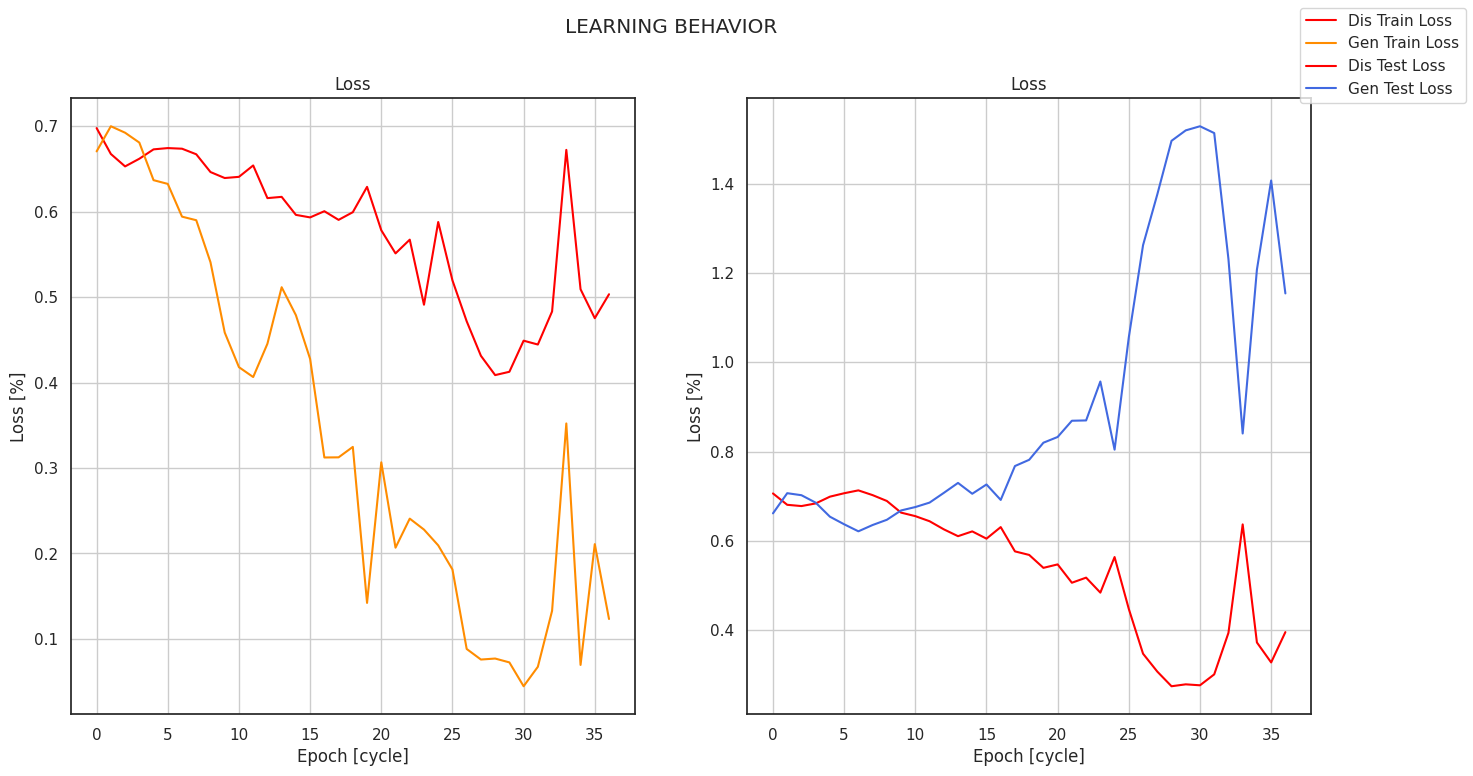

In [46]:

# reporte del aprendizaje
# base de la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# datos de la figura en de perdida y precision
ax1.plot(fashion_logs.history["dis_loss"],
         'red', label="Dis Train Loss")
ax1.plot(fashion_logs.history["gen_loss"],
         'darkorange', label="Gen Train Loss")
ax2.plot(fashion_logs.history["val_dis_loss"],
         'red', label="Dis Test Loss")
ax2.plot(fashion_logs.history["val_gen_loss"],
         'royalblue', label="Gen Test Loss")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Loss")
ax1.set(xlabel="Epoch [cycle]", ylabel="Loss [%]")
ax2.set(xlabel="Epoch [cycle]", ylabel="Loss [%]")
fig.legend()
# fig.show()

## Probar Modelo GAN

### Generar Imágenes

In [47]:
imgs = generator.predict(tf.random.normal((16, lat_neurons, 1)))

1/1 [==============================] - 0s 305ms/step


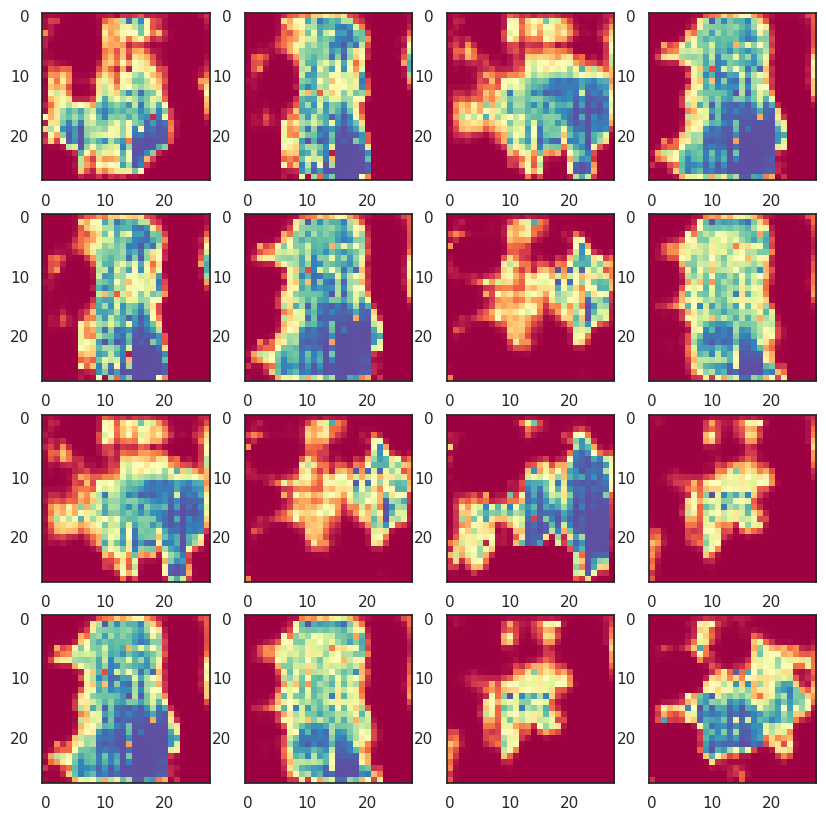

In [48]:

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1],
                        cmap=plt.cm.Spectral)

### Guardar los modelos

In [ ]:
# guardar los modelos, discrinador y generador
wdir = os.getcwd()
folder_models = "Models"
gen_model_fn = "discws_fashion_gan_gen.keras"
dis_model_fn = "discws_fashion_gan_dis.keras"
# tf.keras.models.save_model(cnn_autoencoder, model_fp)

In [ ]:
# guardando generador
model_fp = os.path.join(folder_models, gen_model_fn)
print("El generador entrenado esta en:", model_fp)
generator.save(model_fp)

In [ ]:
# guardando discriminador
model_fp = os.path.join(folder_models, dis_model_fn)
print("El discriminador entrenado esta en:", model_fp)
discriminator.save(model_fp)